In [94]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
engine = create_engine("postgresql:///kc_housing")
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [163]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df

def clean_data_intial(df):
    """ This function cleans the housing data by removing outliers, sale price == 0, and irrelevant columns. 
    """
    #We chose a minimum sale vale of 10000 and a maximium sale value of 2 sigma
    df_clean = df[(df['saleprice']>10000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    df_clean = df_clean[(df_clean['sqftlot'] < (3*df_clean['sqftlot'].std())+df_clean['sqftlot'].mean())]
    #These are irrelevant or highly covariant columns
    columns_to_drop = ['documentdate',
                       'excisetaxnbr',
                       'recordingnbr',
                       'volume',
                       'page',
                       'platnbr',
                       'plattype',
                       'platlot',
                       'platblock',
                        'sellername',
                        'buyername',
                        'streetname',
                        'streettype',
                        'directionsuffix',
                        'zipcode',
                        'buildingnumber',
                        'major',
                        'minor',
                        'bldggradevar',
                        'sqfthalffloor',
                        'sqft2ndfloor',
                        'sqftupperfloor',
                        'sqftunfinfull',
                        'sqftunfinhalf',
                        'sqfttotbasement',
                        'sqftfinbasement',
                        'brickstone',
                        'viewutilization',
                        'propname',
                        'platname',
                        'platlot',
                        'platblock',
                        'range',
                        'township',
                        'section',
                        'quartersection',
                        'area',
                        'subarea',
                        'specarea',
                        'specsubarea',
                        'levycode',
                        'districtname',
                        'currentzoning',
                        'topography',
                        'currentusedesignation',
                        'salewarning',
                        'wetland',
                        'stream',
                        'seismichazard',
                        'landslidehazard',
                        'address',
                        'airportnoise',
                        'contamination',
                        'dnrlease',
                         'coalminehazard',
                         'criticaldrainage',
                         'erosionhazard',
                         'landfillbuffer',
                         'hundredyrfloodplain',
                         'steepslopehazard',
                         'speciesofconcern',
                         'sensitiveareatract',
                         'daylightbasement',
                         'fraction',
                        'directionprefix', 'proptype','unbuildable', 'bldgnbr']
    df_clean.drop(columns=columns_to_drop, inplace = True)
    #The columns with Y or N need to be 1 or 0 to model
    df_clean['othernuisances'] = [i.strip() for i in df_clean['othernuisances']]
    df_clean.replace(('Y', 'N'), (1, 0), inplace=True)
    
    #To model the houses that take up more space of thier plot (smaller yard) we need a ratio feature
    #We assume an acturate metric of the house's footprint is the first floor plus any attached garage. This 
    #unfortunatley may not account for detached garages
    df_clean['footprint_ratio']=(df_clean['sqft1stfloor']+df_clean['sqftgarageattached'])/df_clean['sqftlot']
    df_clean.drop(columns = 'sqft1stfloor', inplace = True)

    return df_clean

def recursive_feature_selection(n_features,indep_variables_df, dep_var):
    """
    n_features = number of features to select
    indep_variables = pandas dataframe containing the features to select from
    dep_var = pandas dataframe containing the feature to model \
    returns a list of features to include in model to best fit line
    """
    lr = LinearRegression()
    select = RFE(lr, n_features_to_select=n_features)
    select = select.fit(indep_variables_df, y= dep_var.values.ravel())
    selected_columns = indep_variables_df.columns[select.support_]
    return selected_columns

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def check_feature_linearity(list_of_features, df, y):
    for column in list_of_features:
        plt.scatter(df[column], y, label=column)
        plt.legend()
        plt.show()
        
def make_housing_model(list_of_features, df, y):
    features = df[list_of_features]
    features = sm.add_constant(features)
    model = sm.OLS(y,features).fit()
    return model, model.summary() 

def check_feature_heteros(list_of_features, df, y):
    """
    Visualizes the heteroscedasticity of a linear model in order to check the 
    assumptions.
    """
    for feature in list_of_features:
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.OLS(y,x).fit()
        fig = plt.figure(figsize=(15,8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show()
        


In [167]:
df = pullsqldata()

In [168]:
df_cleaned = clean_data_intial(df)

In [169]:
# selects features for base model, to answer our initial questions
base_model = df_cleaned[['saleprice','sqfttotliving', 'sqftlot', 'footprint_ratio', 'nbrlivingunits']]

In [170]:
base_model['nbrlivingunits'].value_counts()

1.0    27841
2.0      349
3.0       90
Name: nbrlivingunits, dtype: int64

In [171]:
base_model

,saleprice,sqfttotliving,sqftlot,footprint_ratio,nbrlivingunits
0,310000.0,1200.0,14500.0,0.124138,1.0
3,500000.0,4100.0,16406.0,0.128002,1.0
6,456800.0,1720.0,8620.0,0.183295,1.0
7,461000.0,2840.0,8728.0,0.199358,1.0
8,80000.0,2980.0,12400.0,0.150000,1.0
13,795000.0,3200.0,8092.0,0.240979,1.0
15,440000.0,2180.0,10964.0,0.127691,1.0
16,520000.0,2140.0,8000.0,0.167500,1.0
17,166166.0,2340.0,5900.0,0.198305,1.0
20,97500.0,860.0,5400.0,0.159259,1.0


In [172]:
# drops triplexes from the dataframe
triplex = base_model.loc[base_model['nbrlivingunits'] == 3]
base_model.drop(triplex.index, inplace= True, axis=0) 
# create a duplex column, value of 1 is duplex, 0 is single family
base_model['duplex'] = base_model['nbrlivingunits'] - 1       

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [208]:
# sets features for modeling
Y = base_model['saleprice']
X = base_model.drop(['saleprice', 'sqftlot', 'nbrlivingunits'], axis=1)

In [209]:
# instantiates a y intercept, and then fits the data to a linear regression
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4136.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:35:31   Log-Likelihood:            -3.9588e+05
No. Observations:               28190   AIC:                         7.918e+05
Df Residuals:                   28186   BIC:                         7.918e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.875e+05   5470.733     34.276      0.000    1.77e+05    1.98e+05
sqfttotliving     220.7395      2.049    107.744      0.000     216.724     224.755
footprint_ratio  2.867e+05   1.45e+04     19.703      0.000    2.58e+05    3.15e+05
duplex           7.152e+04   1.64e+04      4.369      0.000    3.94e+04    1.04e+05
==============================================================================
Omnibus:                     3030.777   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7959.297
Skew:                           0.614   Prob(JB):                         0.00
Kurtosis:                       5.295   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [175]:
X_int = sm.add_constant(base_model['sqftlot'])
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     41.54
Date:                Wed, 04 Dec 2019   Prob (F-statistic):           1.17e-10
Time:                        15:00:27   Log-Likelihood:            -4.0100e+05
No. Observations:               28190   AIC:                         8.020e+05
Df Residuals:                   28188   BIC:                         8.020e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.034e+05   2589.198    271.668      0.000    6.98e+05    7.08e+05
sqftlot        0.7881      0.122      6.445      0.000       0.548       1.028
==============================================================================
Omnibus:                     4149.124   Durbin-Watson:                   0.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6423.991
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                       4.044   Cond. No.                     2.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [201]:
f = 'saleprice ~ sqftlot'
model = ols(formula=f, data=base_model).fit()

In [202]:
X_new = pd.DataFrame({'sqftlot': [base_model.sqftlot.min(), base_model.sqftlot.max()]})

In [203]:
preds = model.predict(X_new)

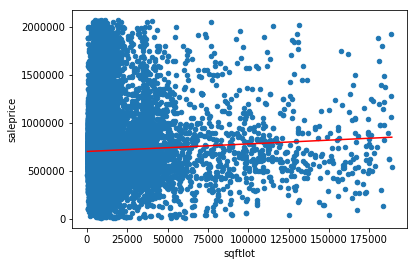

In [204]:
base_model.plot(kind='scatter', x='sqftlot', y='saleprice')
plt.plot(X_new, preds, c='red')

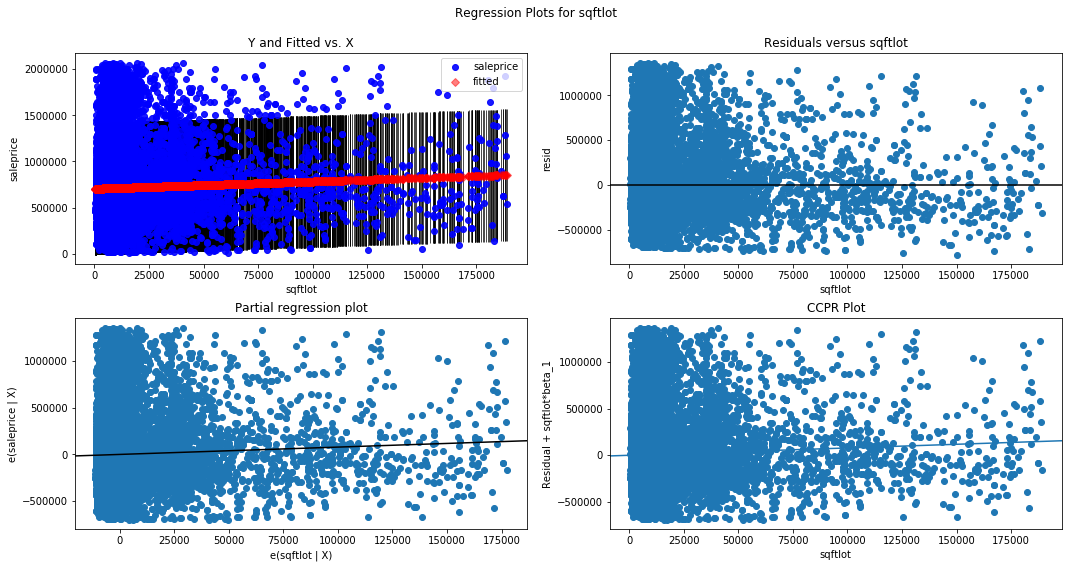

In [205]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqftlot', fig=fig)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


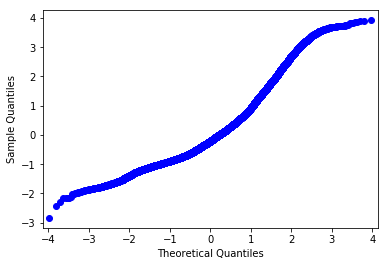

In [197]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True)
fig.show()

In [193]:
base_model['footprint_ratio']

0        0.124138
3        0.128002
6        0.183295
7        0.199358
8        0.150000
13       0.240979
15       0.127691
16       0.167500
17       0.198305
20       0.159259
21       0.100967
22       0.012780
23       0.106874
24       0.089750
27       0.065882
28       0.257843
29       0.183060
32       0.709877
33       0.709877
34       0.469667
36       0.532688
37       0.348432
39       0.396583
41       0.078461
90       0.250554
92       0.207406
93       0.247885
95       0.279224
96       0.245885
97       0.292790
           ...   
43692    0.300000
43693    0.190000
43694    0.190000
43695    0.234936
43697    0.281818
43700    0.197727
43702    0.198529
43703    0.148485
43704    0.260606
43705    0.157025
43706    0.184896
43707    0.180000
43715    0.228865
43717    0.273248
43718    0.312195
43720    0.346667
43721    0.228582
43722    0.547138
43724    0.547138
43725    0.092040
43726    0.100000
43727    0.274972
43728    0.195613
43729    0.131769
43730    0

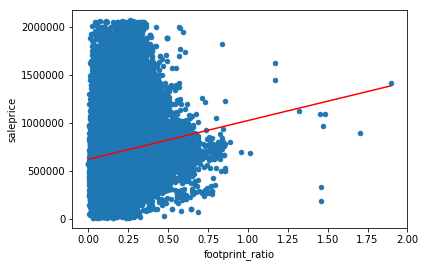

In [195]:
f = 'saleprice ~ footprint_ratio'
model = ols(formula=f, data=base_model).fit()
X_new = pd.DataFrame({'footprint_ratio': [base_model.footprint_ratio.min(), base_model.footprint_ratio.max()]})
preds = model.predict(X_new)
base_model.plot(kind='scatter', x='footprint_ratio', y='saleprice')
plt.plot(X_new, preds, c='red')

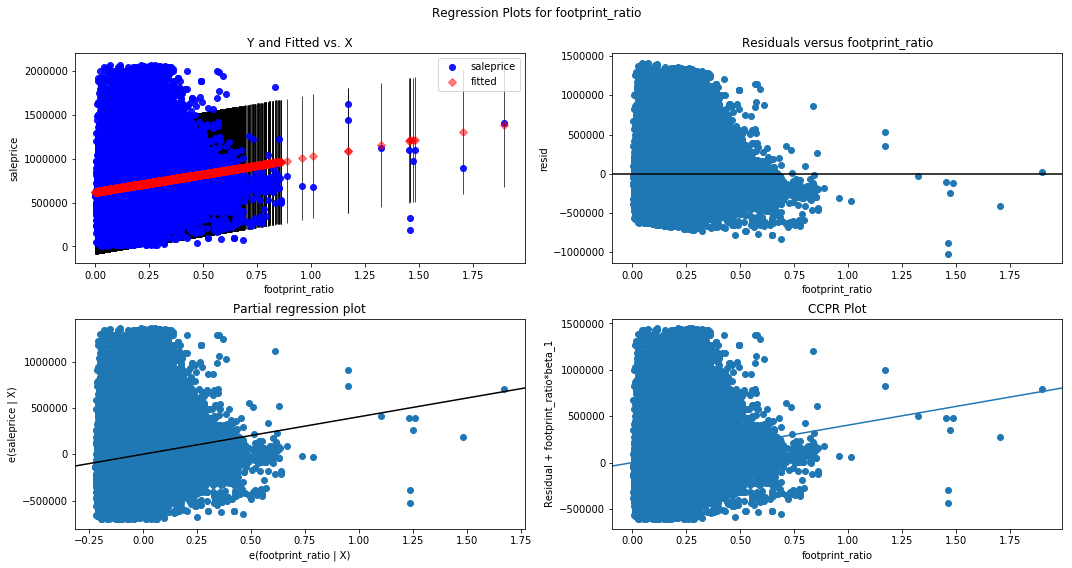

In [196]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'footprint_ratio', fig=fig)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


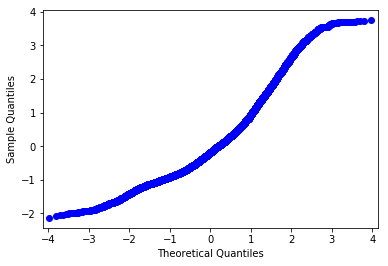

In [187]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True)
fig.show()

# Testing out stepwise model generation

In [243]:
exp_model = df_cleaned.drop(['saleprice'], axis=1)
Y_exp = df_cleaned['saleprice']

In [238]:
X_int = df_cleaned.drop(['saleprice'], axis=1)

In [244]:
stepwise_selection(X_int, Y_exp, X_int)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop principaluse                   with p-value 0.998562
Drop tidelandshoreland              with p-value 0.956661
Drop waterproblems                  with p-value 0.910614
Drop yrrenovated                    with p-value 0.881457
Drop wfntfootage                    with p-value 0.778599
Drop wfntrestrictedaccess           with p-value 0.779151
Drop trafficnoise                   with p-value 0.770809
Drop otherproblems                  with p-value 0.719273
Drop afforestland                   with p-value 0.71529
Drop access                         with p-value 0.656664
Drop afhistoricproperty             with p-value 0.573781
Drop watersystem                    with p-value 0.556106
Drop fpmultistory                   with p-value 0.49355
Drop heatsource                     with p-value 0.479709
Drop wfntpoorquality                with p-value 0.460459
Drop afcurrentuseland               with p-value 0.42692
Drop wfntproximityinfluence         with p-value 0.273329
Drop afnonprofitu

['propertytype',
 'saleinstrument',
 'salereason',
 'propertyclass',
 'nbrlivingunits',
 'stories',
 'bldggrade',
 'sqfttotliving',
 'finbasementgrade',
 'sqftgaragebasement',
 'sqftgarageattached',
 'sqftopenporch',
 'sqftenclosedporch',
 'bedrooms',
 'bathhalfcount',
 'bath3qtrcount',
 'bathfullcount',
 'fpsinglestory',
 'fpfreestanding',
 'fpadditional',
 'yrbuilt',
 'pcntcomplete',
 'pcntnetcondition',
 'condition',
 'addnlcost',
 'hbuasifvacant',
 'hbuasimproved',
 'presentuse',
 'sqftlot',
 'sewersystem',
 'restrictiveszshape',
 'inadequateparking',
 'pcntunusable',
 'mtrainier',
 'olympics',
 'territorial',
 'seattleskyline',
 'lakewashington',
 'lakesammamish',
 'smalllakerivercreek',
 'wfntlocation',
 'wfntbank',
 'wfntaccessrights',
 'lotdepthfactor',
 'powerlines',
 'othernuisances',
 'nbrbldgsites',
 'adjacentgolffairway',
 'adjacentgreenbelt',
 'historicsite',
 'nativegrowthprotesmt',
 'easements',
 'otherdesignation',
 'deedrestrictions',
 'footprint_ratio']

In [242]:
len(base_model) == len(Y)

True

In [246]:
make_housing_model(stepwise_selection(X_int, Y_exp, X_int), X_int, Y_exp)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop principaluse                   with p-value 0.998562
Drop tidelandshoreland              with p-value 0.956661
Drop waterproblems                  with p-value 0.910614
Drop yrrenovated                    with p-value 0.881457
Drop wfntfootage                    with p-value 0.778599
Drop wfntrestrictedaccess           with p-value 0.779151
Drop trafficnoise                   with p-value 0.770809
Drop otherproblems                  with p-value 0.719273
Drop afforestland                   with p-value 0.71529
Drop access                         with p-value 0.656664
Drop afhistoricproperty             with p-value 0.573781
Drop watersystem                    with p-value 0.556106
Drop fpmultistory                   with p-value 0.49355
Drop heatsource                     with p-value 0.479709
Drop wfntpoorquality                with p-value 0.460459
Drop afcurrentuseland               with p-value 0.42692
Drop wfntproximityinfluence         with p-value 0.273329
Drop afnonprofitu

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c27e594e0>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              saleprice   R-squared:                       0.511
 Model:                            OLS   Adj. R-squared:                  0.510
 Method:                 Least Squares   F-statistic:                     535.6
 Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
 Time:                        16:47:02   Log-Likelihood:            -3.9224e+05
 No. Observations:               28280   AIC:                         7.846e+05
 Df Residuals:                   28224   BIC:                         7.851e+05
 Df Model:                          55                                         
 Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|    